# Overview
The objective of this notebook is to combine data from all 70 patients and generate several models for prediction based on the time / code reading

In [202]:
# Imports
import pandas as pd
import plotly.express as px
import glob
import datetime

## Data Preparation
As we saw in the our single patient analysis, there is a good chance we may find some outlier values in the lower end that may be misrepresented within the dataset.Let's load the full dataset and explore some insights on unusual values.

In [203]:
files = glob.glob('./dataset/*')

entries = []

for file in files:
    df = pd.read_csv(file, delim_whitespace=True, header=None)
    entries.append(df)

df = pd.concat(entries, axis=0)
df = df.dropna()

df.columns = ['Date', 'Time', 'Code', 'BG']

df.head()


,Date,Time,Code,BG
0,08-03-1990,06:31,56,207
1,08-03-1990,06:33,58,120
2,08-03-1990,11:36,60,42
3,08-03-1990,19:17,62,83
4,08-03-1990,21:37,64,150


### Pre-cleaning insights
Let's take a look at the datset before we remove any NaN values.

In [204]:
df.describe()

,Date,Time,Code,BG
count,29264,29264,29264,29264
unique,1141,1295,29,691
top,09-19-1990,08:00,33,6
freq,126,3101,8676,2017


In [205]:
df['BG'].value_counts()

BG
6      2017
0      1223
3      1194
4      1105
2      1049
       ... 
126       1
219       1
198       1
257       1
404       1
Name: count, Length: 691, dtype: int64

In [206]:
df['Code'].value_counts()

Code
33    8676
34    3563
58    3252
62    2888
60    2498
48    1621
35    1053
57     990
64     904
33     809
65     331
67     326
60     273
62     272
34     267
58     266
48     262
63     219
66     154
70     139
56     119
71      98
72      94
69      68
61      66
68      34
59      20
4        1
36       1
Name: count, dtype: int64

#

### Cleaning
It appears some records may be corrupted with chars, so lets start by removing those. It also appears there are quite a lot of values within a deadly range, so lets remove those as well.

In [207]:
df[['Code']] = df[['Code']].apply(pd.to_numeric, errors='coerce')
df[['BG']] = df[['BG']].apply(pd.to_numeric, errors='coerce')


df = df.dropna()
df['Code'].value_counts()

Code
33    9485
34    3830
58    3518
62    3158
60    2768
48    1881
35    1053
57     989
64     904
65     331
67     326
63     219
66     154
70     139
56     119
71      98
72      94
69      68
61      66
68      34
59      20
4        1
36       1
Name: count, dtype: int64

In [208]:
df = df[df['BG'] > 40]
df['BG'].describe()

count    13417.000000
mean       162.412015
std         79.160660
min         41.000000
25%        100.000000
50%        151.000000
75%        210.000000
max        501.000000
Name: BG, dtype: float64

### DateTime
It might be useful to use a datetime for visualization and model prediction later on, so lets combine the Date and Time columns together.

In [209]:
# format the time column to remove any leading zeros, taking into account a mixed input format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.strftime('%H:%M')

# combine the date and time columns, taking into acccount it may be in different formats
df['DateTime'] = df['Date'] + ' ' + df['Time']
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Visualization
Now that the dataset is clean, let's take a look at some visualizations of our data.

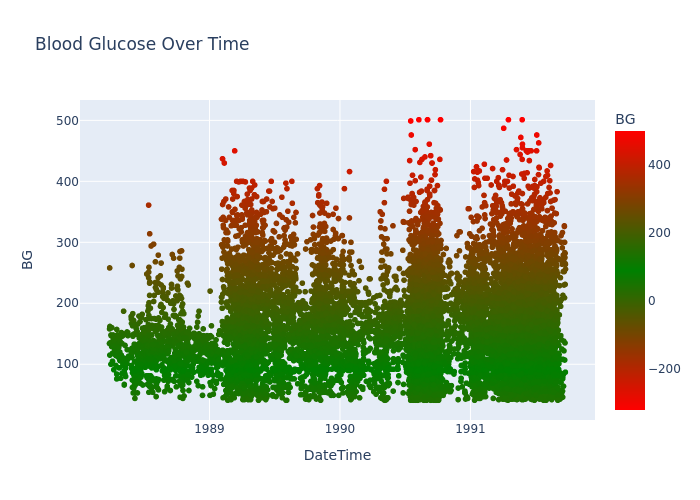

In [210]:
# scatter plot of blood glucose over time
fig = px.scatter(df, x='DateTime', y='BG', title='Blood Glucose Over Time', color='BG', color_continuous_scale=[(0, "red"), (0.5,"green"), (1.0,"red")], color_continuous_midpoint=90)
fig.show("png")

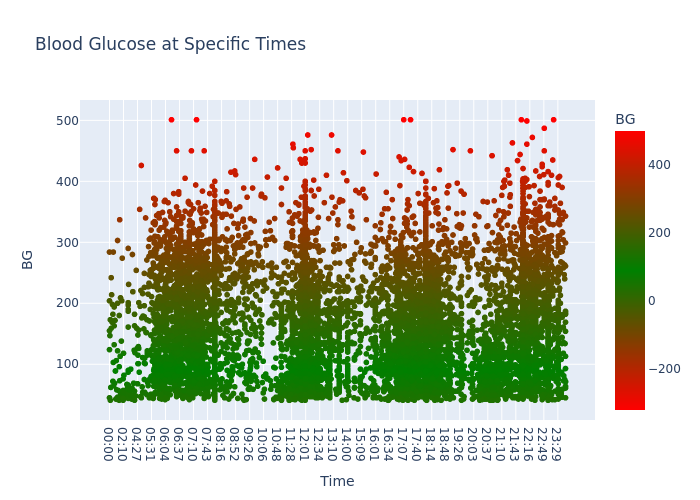

In [211]:
fig = px.scatter(df, x='Time', y='BG', title='Blood Glucose at Specific Times', color='BG', color_continuous_scale=[(0, "red"), (0.5,"green"), (1.0,"red")], color_continuous_midpoint=90)
fig.update_xaxes(categoryorder='category ascending')
fig.show("png")

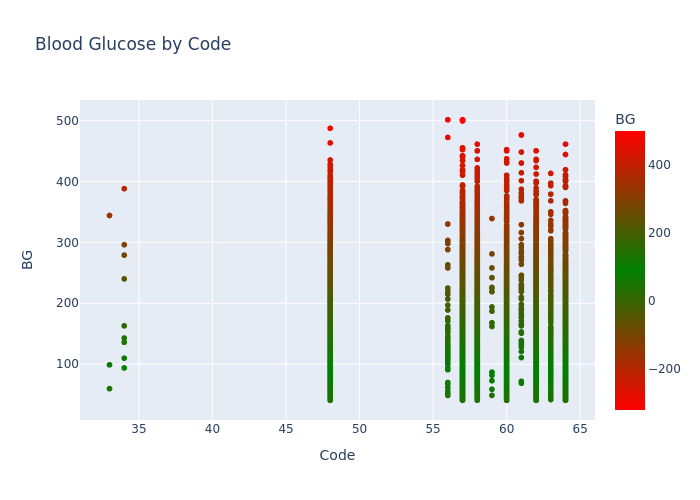

In [212]:
fig = px.scatter(df, x='Code', y='BG', title='Blood Glucose by Code', color='BG', color_continuous_scale=[(0, "red"), (0.5,"green"), (1.0,"red")], color_continuous_midpoint=90)
fig.show("png")

# Model Selection
These visualizations show a vast amount of data varied data that we can use to train a model with. Let's use a RandomForest model from Sklearn to simulate a time-step decision tree.

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

df['Time'] = df['Time'].astype(str).apply(lambda x: x.replace(':', ''))

X = df[['Time']]
Y = df[['BG']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [217]:
model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=1000))
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

/home/bryan/Documents/github/diabetes-analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



-0.044480720200878565

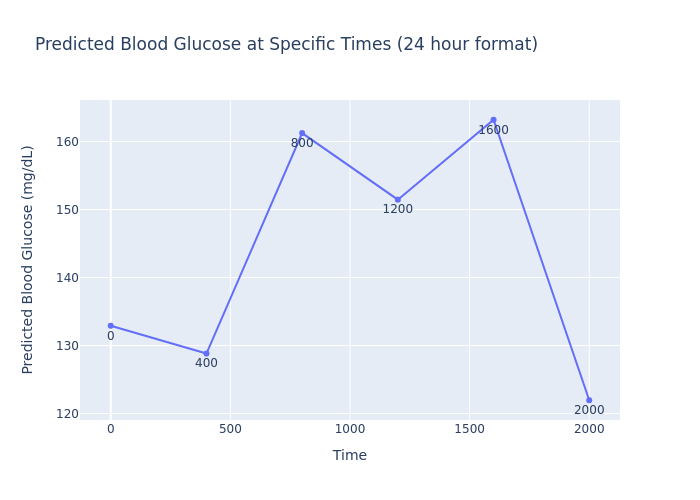

In [269]:
now = datetime.datetime.now()
now = now.strftime('%H%M')
A = pd.DataFrame([0, 400, 800, 1200, 1600, 2000], columns=['Time'])
B = model.predict(A)
C = pd.concat([A, pd.DataFrame(B, columns=['BG'])], axis=1)
fig = px.line(C, x='Time', y='BG', title='Predicted Blood Glucose at Specific Times (24 hour format)', text='Time', labels={'BG':'Predicted Blood Glucose (mg/dL)'})
fig.update_traces(textposition="bottom center")
fig.show("png")

# Reflection
There are a number of reasons this model may not perform well on the test set, but is performing well when given a daily time series. My hypothesis is that most likely a more diviserse model is needed to handle the complexities associated with diabetes.  Many factors including weight, age, activity level, how long you have been diabetic for, diet, etc that influence a person's blood sugar over time, and not every patient gets better after they receive their diagnosis. I believe that data for a longer period of time and from more patients would help smooth out the model, along with some further fine-tuning of its hyperparameters. 